In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


#importing own scripts
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.join(os.path.dirname(current_dir), 'scripts'))
import own_scripts

#Configure max columns display
pd.set_option('max_columns', 200)

#reading raw data
df = pd.read_json(path_or_buf='../data/cocktail_dataset.json')

In this approach we will try to represents each cocktail ingredients as list of indexes. All the ingredients will be stored in another DataFrame.

In [2]:
#Unpacking and replacing the column
ingredients, df['ingredientsID'] = own_scripts.unpack_and_assign_id(df['ingredients'])

In [3]:
display(df.head(1), ingredients.head(1))

,id,name,category,glass,tags,instructions,imageUrl,alcoholic,createdAt,updatedAt,ingredients,ingredientsID
0,11000,Mojito,Cocktail,Highball glass,"[IBA, ContemporaryClassic, Alcoholic, USA, Asi...",Muddle mint leaves with sugar and lime juice. ...,https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:17.000+00:00,2024-08-18T19:06:16.000+00:00,"[{'id': 170, 'name': 'Soda water', 'descriptio...","[170, 305, 312, 337, 476]"


,id,name,description,alcohol,type,percentage,imageUrl,createdAt,updatedAt,measure
0,170,Soda water,None,1,None,NaN,None,2024-08-18T19:01:57.000+00:00,2024-08-18T19:01:57.000+00:00,NaN


We drop some collumn as previously:

    imageUrl - unnecessary in our analysis
    
    ingredients - we store those in another DataFrame

    tags - missing values

    alcoholic - every drink is alcoholic

    measure - not normalized

In [4]:
df = df.drop(columns = ['imageUrl', 'ingredients', 'tags', 'alcoholic'])
ingredients = ingredients.drop(columns = ['imageUrl', 'measure'])

In [5]:
display(df.head(1), ingredients.head(1))

,id,name,category,glass,instructions,createdAt,updatedAt,ingredientsID
0,11000,Mojito,Cocktail,Highball glass,Muddle mint leaves with sugar and lime juice. ...,2024-08-18T19:01:17.000+00:00,2024-08-18T19:06:16.000+00:00,"[170, 305, 312, 337, 476]"


,id,name,description,alcohol,type,percentage,createdAt,updatedAt
0,170,Soda water,None,1,None,NaN,2024-08-18T19:01:57.000+00:00,2024-08-18T19:01:57.000+00:00


Now we will 'correct' datatypes in time and percentage sections.

In [6]:
for header in ['percentage']:
    ingredients[header] = ingredients[header].apply(lambda a: 0 if pd.isna(a) else a)

df['createdAt'] = pd.to_datetime(df['createdAt'])
df['updatedAt'] = pd.to_datetime(df['updatedAt'])

ingredients['createdAt'] = pd.to_datetime(ingredients['createdAt'])
ingredients['updatedAt'] = pd.to_datetime(ingredients['updatedAt'])

In [7]:
display(df.head(1), ingredients.head(1))

,id,name,category,glass,instructions,createdAt,updatedAt,ingredientsID
0,11000,Mojito,Cocktail,Highball glass,Muddle mint leaves with sugar and lime juice. ...,2024-08-18 19:01:17+00:00,2024-08-18 19:06:16+00:00,"[170, 305, 312, 337, 476]"


,id,name,description,alcohol,type,percentage,createdAt,updatedAt
0,170,Soda water,None,1,None,0.0,2024-08-18 19:01:57+00:00,2024-08-18 19:01:57+00:00


This time we will simplify instructions to the length of the instruction as well as before.

In [8]:
df['instructions'] = df['instructions'].apply(lambda a: len(a))
df.rename(columns={'instructions': 'instructionLength'}, inplace=True)

In [9]:
df.head(1)

,id,name,category,glass,instructionLength,createdAt,updatedAt,ingredientsID
0,11000,Mojito,Cocktail,Highball glass,177,2024-08-18 19:01:17+00:00,2024-08-18 19:06:16+00:00,"[170, 305, 312, 337, 476]"


# EDA - in this section we will try visualize properties and answer some questions about the dataset.

## Question: Is there any relationship between instruction length and number of used ingredients?

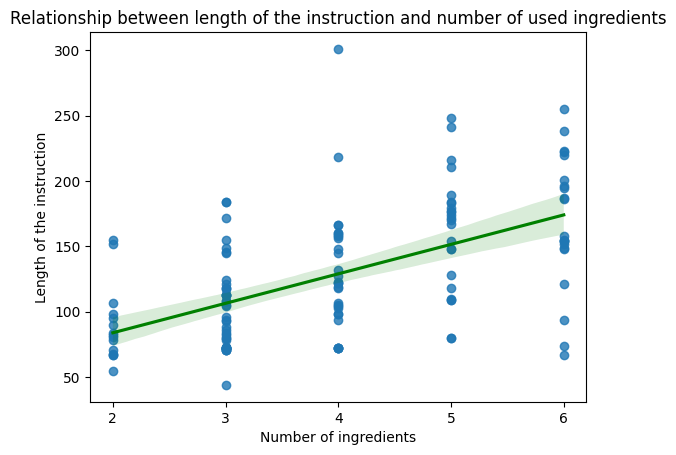

In [10]:
ax = sns.regplot(
            x = df['ingredientsID'].apply(lambda a: len(a)), 
            y = df['instructionLength'],  
            # ci = None,
            data = df,
            line_kws={'color' : 'green'})

ax.set_title('Relationship between length of the instruction and number of used ingredients')
ax.set_xlabel('Number of ingredients')
ax.set_ylabel('Length of the instruction')
ax.set_xticks([2, 3, 4, 5, 6])
plt.show()

## Answer: As the legth of the instruction exceeds the average number of used ingredients grows.

## Question: What's the trend of the updating cocktails and ingredients?

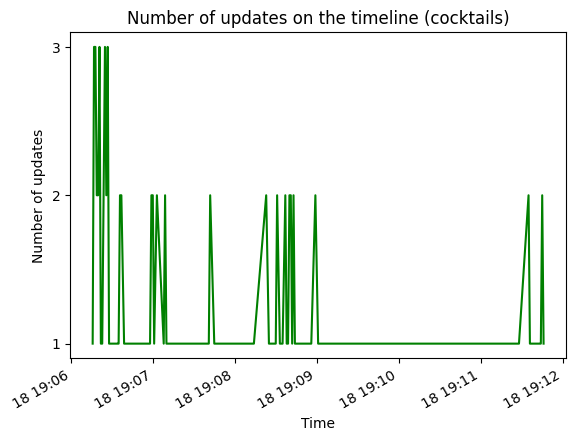

In [11]:
ax = df['updatedAt'].value_counts().plot(title='', color='green')
ax.set_title('Number of updates on the timeline (cocktails)')
ax.set_xlabel('Time')
ax.set_ylabel('Number of updates')
ax.set_yticks([1, 2, 3])
plt.show()

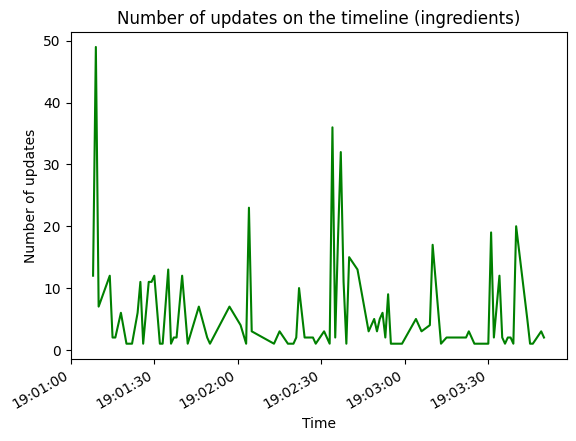

In [12]:
ax = ingredients['updatedAt'].value_counts().plot(title='', color='green')
ax.set_title('Number of updates on the timeline (ingredients)')
ax.set_xlabel('Time')
ax.set_ylabel('Number of updates')
plt.show()

## Answer: Both datasets were updated the most at around 19:01. Cocktails seems to have updates in more organised way - peaks of updates are close to each other. Ingredients seems to be updated more randomly on the timeline - the timeline is streched widely (compared to cocktails).

note: Both updates were probably done by script but we are here to learn and analise. :) 

## Question: According to the plot below there is around 25 drinks in Old-fashioned glass. Which ingredient is the most used in such glass?

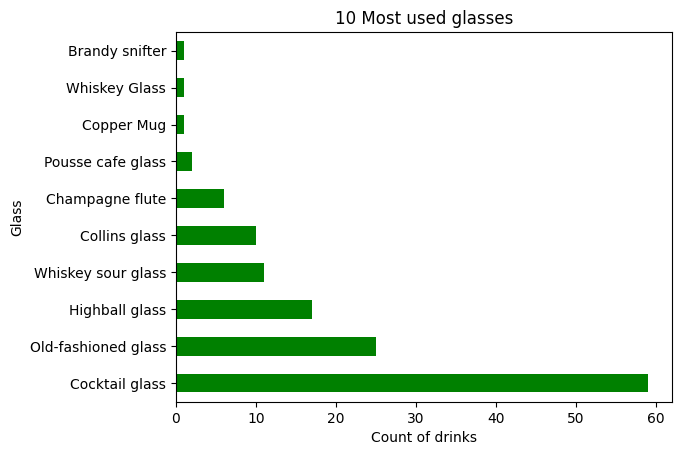

In [13]:
ax = df['glass'].value_counts().head(10).plot(kind='barh', title='10 Most used glasses', color='green')
ax.set_xlabel('Count of drinks')
ax.set_ylabel('Glass')
plt.show()

## Code:

In [18]:
counts = own_scripts.analyze_ingredients(df.query('glass == "Old-fashioned glass"'), ingredients)
ans = max(counts, key=counts.get)

# printing
ans, counts[ans]

('Powdered Sugar', 15)

## Answer: Most used ingredient in this type of the glass is 'Powdered Sugar'.